In [ ]:
import pandas as pd
import numpy as np
import requests
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url1 = 'https://ufal.mff.cuni.cz/~pecina/courses/npfl067/data/TEXTEN1.txt'
url2 = 'https://ufal.mff.cuni.cz/~pecina/courses/npfl067/data/TEXTCZ1.txt'

In [ ]:
def get_data(url):
  " returns list of worlds and list of characters"

  # read txt data
  data = requests.get(url)
  data.encoding = 'iso-8859-2'
  data = data.text.split('\n')[:-1]

  characters = set()
  for word in data :
    for ch in word :characters.add(ch)
  characters = list(characters)

  vocab = np.unique(np.array(data)).tolist()
  return data, characters, vocab

def put_to_dict(key, dc):
  # put key in dictionary
  if  key not in dc:
    dc[key] = 1
  else:
    dc[key] +=1

def compute_counts(data):
  # compute count of bigrams and unigrams
  text_length = len(data)
  pairs_counts = dict()
  word_counts = dict()

  for i in range(text_length-1):
    word1 = data[i]
    word2 = data[i+1]

    put_to_dict((word1, word2), pairs_counts)
    put_to_dict(word1, word_counts)

    if word2 == '.' and i+2 < text_length-1:
      word3 = data[i+2]
      put_to_dict((word1, word3),pairs_counts)

  put_to_dict(data[-1], word_counts)

  return word_counts, pairs_counts

In [ ]:
def compute_entropy(text_length, pairs_counts, word_counts):
  #compute joint and conditional probabilities
  prob_pairs = dict()
  cprob_pairs = dict()

  for pair,count in pairs_counts.items():
    prob_pairs[pair] = count / (text_length + word_counts['.'] - 2)

    w_i1, w_i = pair
    cprob_pairs[(w_i, w_i1)] = count / word_counts[w_i1]

  # compute entropy
  entropy = 0
  for pair in pairs_counts:
    w_i1, w_i = pair
    entropy += prob_pairs[pair] * math.log(cprob_pairs[(w_i, w_i1)], 2)
  return -entropy


In [ ]:
import random
def map_character(ch, characters, mess_prob):
  # map character to random character from characters with probability mess_prob
  if random.random() < mess_prob:
    new_character = characters[random.randrange(0,len(characters))]
    return new_character
  return ch

def mess_up_text(text, mess_prob, vocab, characters, w = False):
  # mess up word if w = True (else characters) with probability mess_prob

  messed_text = []
  for word in text:
    new_word =''
    if w:
      # map word to random word from vocab
      if random.random() < mess_prob:
        new_word = vocab[random.randrange(0, len(vocab))]
      else:
        new_word = word
    else:
      # mess up characters in word
      for ch in word: new_word += map_character(ch, characters, mess_prob)

    messed_text.append(new_word)
  return messed_text

def experiment(data, characters, vocabulary, mess_prob, w = False):
  "mess up the original text with given params and compute entropy 10 times"
  history = []
  for i in range(10):
    text = mess_up_text(text = data, characters = characters, vocab= vocabulary, mess_prob=mess_prob, w = w)
    w_counts, p_counts = compute_counts(data=text)
    e = compute_entropy(len(text), word_counts=w_counts, pairs_counts=p_counts)
    history.append(e)
  return np.array(history)


In [ ]:
# make entropy experiment for both files for diffrent mess up probabilities from assignment icluding 0
results = {'mutate_prob':[], 'min_entropy':[], "max_entropy":[], "mean":[], 'word_mess_up':[], 'perplexity' : [], 'data_file':[]}

for url, name in (url1, 'ENG'), (url2, 'CZK'):
  data, char, vocab = get_data(url)
  for mess_prob in 0, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001:
    for mess_words in False, True:
      entropy = experiment(data = data, vocabulary=vocab, characters=char, mess_prob=mess_prob, w = mess_words)
      results['mutate_prob'].append(mess_prob)
      results['min_entropy'].append(entropy.min())
      results['max_entropy'].append(entropy.max())
      results['mean'].append(entropy.mean())
      results['word_mess_up'].append(mess_words)
      results['perplexity'].append(2**entropy.mean())
      results['data_file'].append(name)

In [ ]:
results = pd.DataFrame(results)
results.head(5)

,mutate_prob,min_entropy,max_entropy,mean,word_mess_up,perplexity,data_file
0,0.00,5.280207,5.280207,5.280207,False,38.859809,ENG
1,0.00,5.280207,5.280207,5.280207,True,38.859809,ENG
2,0.10,4.678923,4.686072,4.683001,False,25.687623,ENG
3,0.10,5.440694,5.450515,5.445522,True,43.577806,ENG
4,0.05,5.017367,5.026767,5.021101,False,32.471464,ENG


In [ ]:
print('entropy and perplexity for ENGLISH data and CHARACTER exchange')
results[(results['data_file'] == 'ENG') & (results['word_mess_up'] == False)][['mutate_prob', 'min_entropy','mean','max_entropy', 'perplexity']]. sort_values(by = 'mutate_prob')

entropy and perplexity for ENGLISH data and CHARACTER exchange


,mutate_prob,min_entropy,mean,max_entropy,perplexity
0,0.00000,5.280207,5.280207,5.280207,38.859809
12,0.00001,5.280138,5.280175,5.280225,38.858949
10,0.00010,5.279343,5.279774,5.279937,38.848137
8,0.00100,5.274775,5.275833,5.276486,38.742173
6,0.01000,5.234133,5.236149,5.239104,37.691032
4,0.05000,5.017367,5.021101,5.026767,32.471464
2,0.10000,4.678923,4.683001,4.686072,25.687623


In [ ]:
print('entropy and perplexity for ENGLISH data and WORD exchange')
results[(results['data_file'] == 'ENG') & (results['word_mess_up'] == True)][['mutate_prob', 'min_entropy','mean','max_entropy', 'perplexity']].sort_values(by = 'mutate_prob')

entropy and perplexity for ENGLISH data and WORD exchange


,mutate_prob,min_entropy,mean,max_entropy,perplexity
1,0.00000,5.280207,5.280207,5.280207,38.859809
13,0.00001,5.280190,5.280228,5.280300,38.860365
11,0.00010,5.280222,5.280348,5.280437,38.863613
9,0.00100,5.281699,5.282049,5.282590,38.909456
7,0.01000,5.297515,5.298748,5.300760,39.362443
5,0.05000,5.368469,5.370597,5.376397,41.372410
3,0.10000,5.440694,5.445522,5.450515,43.577806


In [ ]:
print('entropy and perplexity for CZECH data and CHARACTER exchange')
results[(results['data_file'] == 'CZK') & (results['word_mess_up'] == False)][['mutate_prob', 'min_entropy','mean','max_entropy', 'perplexity']]. sort_values(by = 'mutate_prob')#

entropy and perplexity for CZECH data and CHARACTER exchange


,mutate_prob,min_entropy,mean,max_entropy,perplexity
14,0.00000,4.676353,4.676353,4.676353,25.569513
26,0.00001,4.676194,4.676269,4.676352,25.568032
24,0.00010,4.675142,4.675392,4.675553,25.552490
22,0.00100,4.666802,4.667318,4.668127,25.409883
20,0.01000,4.583540,4.584918,4.587861,23.999255
18,0.05000,4.258035,4.262307,4.269447,19.190320
16,0.10000,3.928787,3.932902,3.940450,15.272899


In [ ]:
print('entropy and perplexity for CZECH data and WORD exchange')
results[(results['data_file'] == 'CZK') & (results['word_mess_up'] == True)][['mutate_prob', 'min_entropy','mean','max_entropy', 'perplexity']]. sort_values(by = 'mutate_prob')#.to_latex(index = False)

entropy and perplexity for CZECH data and WORD exchange


,mutate_prob,min_entropy,mean,max_entropy,perplexity
15,0.00000,4.676353,4.676353,4.676353,25.569513
27,0.00001,4.676306,4.676342,4.676381,25.569316
25,0.00010,4.676188,4.676299,4.676420,25.568566
23,0.00100,4.675523,4.675849,4.676317,25.560582
21,0.01000,4.667013,4.668274,4.669012,25.426736
19,0.05000,4.628162,4.632589,4.635663,24.805522
17,0.10000,4.571674,4.576105,4.577786,23.853106


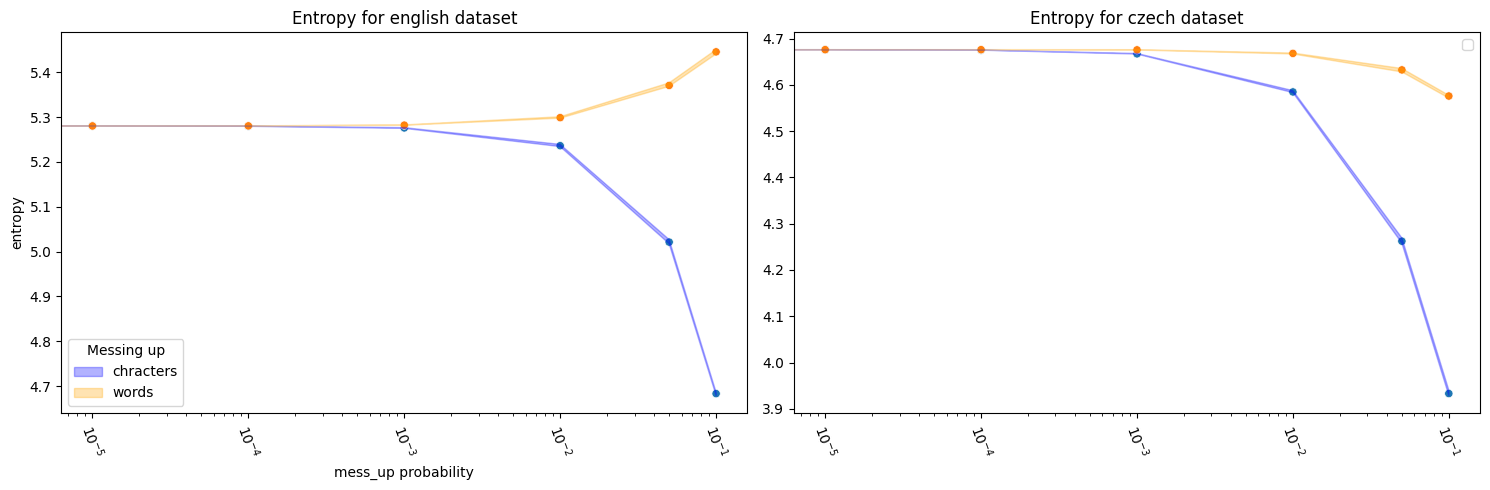

In [ ]:
# plot entropy for each mess up probability for both datasets

figure, ax = plt.subplots(1,2,figsize = (15,5))
eng = results[results['data_file'] == 'ENG'].sort_values(by = 'mutate_prob')
sns.scatterplot(eng, x='mutate_prob', y = 'mean', hue = 'word_mess_up', ax=ax[0], legend = False)

ax[0].fill_between(x = eng[eng['word_mess_up'] == False].mutate_prob, y1 = eng[eng['word_mess_up'] == False].max_entropy, y2 = eng[eng['word_mess_up'] == False].min_entropy, alpha = 0.3, color = 'blue', label = 'chracters')
ax[0].fill_between(x = eng[eng['word_mess_up'] == True].mutate_prob, y1 = eng[eng['word_mess_up'] == True].max_entropy, y2 = eng[eng['word_mess_up'] == True].min_entropy, alpha = 0.3, color = 'orange', label = 'words')

ax[0].set_title('Entropy for english dataset')
ax[0].set_xticks(eng.mutate_prob)
ax[0].set_xticklabels(eng.mutate_prob, rotation = -70)
ax[0].set_xlabel('mess_up probability')
ax[0].set_ylabel('entropy')
ax[0].legend(title = 'Messing up', loc = 3)
ax[0].set_xscale('log')

czk = results[results['data_file'] == 'CZK'].sort_values(by = 'mutate_prob')
czk_w = czk[czk['word_mess_up'] == False]
czk_ch = czk[czk['word_mess_up'] == True]
sns.scatterplot(czk, x='mutate_prob', y = 'mean', hue = 'word_mess_up', ax=ax[1])

ax[1].fill_between(x = czk_w.mutate_prob, y1 = czk_w.max_entropy, y2 = czk_w.min_entropy, alpha = 0.3, color = 'blue')
ax[1].fill_between(x = czk_ch.mutate_prob, y1 = czk_ch.max_entropy, y2 = czk_ch.min_entropy, alpha = 0.3, color = 'orange')

ax[1].set_title('Entropy for czech dataset')
ax[1].set_xticks(czk.mutate_prob)
ax[1].set_xticklabels(czk.mutate_prob, rotation = -70)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend(())
ax[1].set_xscale('log')

plt.tight_layout()

**Characteristics of languages**

In [ ]:
data_ENG, char_ENG, vocab_ENG = get_data(url1)
data_CZK, char_CZK, vocab_CZK = get_data(url2)

In [ ]:
word_c_ENG, pairs_c_ENG = compute_counts(data_ENG)
word_c_CZK, pairs_c_CZK = compute_counts(data_CZK)

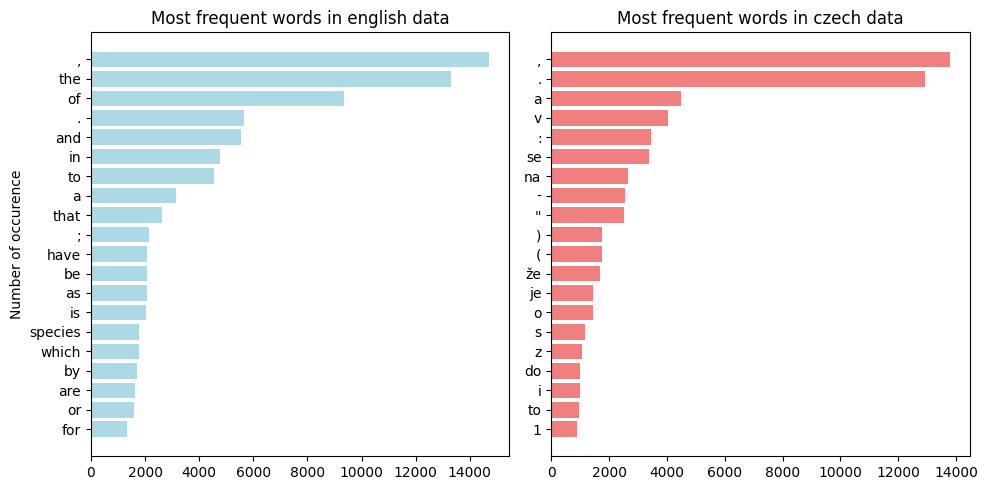

In [ ]:
# extract 20 most frequent words from word_counts of both data files and plot as barplot

sorted_data1 = dict(sorted(word_c_ENG.items(), key=lambda item: item[1]))
sorted_data2 = dict(sorted(word_c_CZK.items(), key=lambda item: item[1]))

k = 20
categories1 = list(sorted_data1.keys())[-k:]
values1 = list(sorted_data1.values())[-k:]

categories2 = list(sorted_data2.keys())[-k:]
values2 = list(sorted_data2.values())[-k:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.barh(categories1, values1, color='lightblue')
ax1.set_ylabel('Number of occurence')
ax1.set_title('Most frequent words in english data')

ax2.barh(categories2, values2, color='lightcoral')
ax2.set_title('Most frequent words in czech data')
plt.tight_layout()

In [ ]:
# compute characters per word
total_char_EN, total_char_CZ = sum(map(len, data_ENG)), sum(map(len, data_CZK))
letter_per_word_EN = total_char_EN/ len(data_ENG)
letter_per_word_CZK = total_char_CZ/ len(data_CZK)


In [ ]:
# compute number of words with frequency 1
one_occ_EN, one_occ_CZ = 0, 0
for key,value in word_c_ENG.items() :
  if value == 1 : one_occ_EN +=1
for key,value in word_c_CZK.items() :
  if value == 1 : one_occ_CZ +=1

In [ ]:
# store results in table, icluding also vocabulary size, total word counts, ...
data = {
    'Language': ['English', 'Czech'],
    'Word_Count': [len(data_ENG), len(data_CZK)],
    'Vocabulary size' :[len(vocab_ENG), len(vocab_CZK)],
    'Total_Char_Count': [total_char_EN, total_char_CZ],
    'Unique_chr_count': [len(char_ENG), len(char_CZK)],
    'Avg_Word_Length': [letter_per_word_EN, letter_per_word_CZK],
    'Freq1_Words': [one_occ_EN, one_occ_CZ]
}

df = pd.DataFrame(data)
df

,Language,Word_Count,Vocabulary size,Total_Char_Count,Unique_chr_count,Avg_Word_Length,Freq1_Words
0,English,221098,9607,972917,74,4.400388,3811
1,Czech,222412,42826,1030631,117,4.633882,26315


## **Language modelling and smoothig**

In [ ]:
# divide data into train, heldout and test sets
t,h = 20000, 40000
test_data_EN, test_data_CZ = data_ENG[-t:], data_CZK[-t:]
heldout_data_EN, heldout_data_CZ = data_ENG[-(t+h):-t], data_CZK[-(t+h):-t]
train_data_EN, train_data_CZ = data_ENG[:-(t+h)], data_CZK[:-(t+h)]

In [ ]:
def compute_counts_n_grams(text):
  # compute c3 - counts for trigrams
  c3 = dict()
  text = ['<S>', '<S>'] + text + ['<S>', '<S>']
  for i in range(len(text)-2):
     trigram = (text[i], text[i+1],text[i+2])
     c3[trigram] = c3.get(trigram, 0) + 1

  # compute c2 - bigram counts from c3
  c2 = dict()
  for (w_i2, w_i1, w_i), count in c3.items():
      c2[(w_i2, w_i1)] = c2.get((w_i2, w_i1), 0) + count

  #compute c1 from c2
  c1 = dict()
  for (w_i1, w_i), count in c2.items():
    c1[w_i1] = c1.get(w_i1, 0) + count
  return c3, c2, c1

In [ ]:
def compute_probs_n_grams(text):
  # for text compute p0,...,p3 distributions

  c3, c2, c1 = compute_counts_n_grams(text)
  p_0 = 1/len(c1)
  p_1 = dict(zip(c1.keys(), np.array(list(c1.values())) / len(text)))

  p_2 = dict()
  for bigram, count in c2.items():
    w_i1, w_i = bigram
    p_2[(w_i, w_i1)] = count/c1[w_i1]

  p_3 = dict()
  for trigram, count in c3.items():
    w_i2, w_i1, w_i = trigram
    p_3[(w_i, w_i2, w_i1)] = count/c2[(w_i2, w_i1)]

  return p_0, p_1, p_2, p_3


In [ ]:
def expectation_maximisation(probs, held_data):
  # EM algorithm with threshold 10^(-6) for given p0,..,p4 as probs and heldout data held_data
  p0, p1, p2, p3 = probs
  lamb = np.array([0.25,0.25,0.25,0.25])
  expected_counts = np.zeros(4)

  for epoch in range(1000000):
    # for heldout data compute p_lambda an update expected counts of lambdas
    for i in range(len(held_data)-2):
      hi2, hi1, wi = held_data[i], held_data[i+1], held_data[i+2]

      p_from_train = np.array([p0, p1.get(wi, 0), p2.get((wi,hi1),p0), p3.get((wi,hi2,hi1),p0)])
      p_lambda = lamb @ p_from_train

      current_c = np.array([lamb[0] * p0, lamb[1] * p1.get(wi,0), lamb[2] * p2.get((wi,hi1),p0), lamb[3] * p3.get((wi,hi2,hi1),p0) ]) / p_lambda
      expected_counts += current_c

    # compute lambda_next and check termination condition
    lamb_next = expected_counts / expected_counts.sum()
    if ((epoch + 1) % 100) == 0 :print('number of epochs : ', epoch + 1, 'lambda coefs: ', lamb)

    if (np.abs(lamb - lamb_next) < 10**(-6)).all():
      break
    lamb = lamb_next

  print('number of epochs : ', epoch + 1, 'lambda coefs: ', lamb)
  return lamb

In [ ]:
# compute n_grams probabilities for train data
probs_EN = compute_probs_n_grams(train_data_EN)
probs_CZ= compute_probs_n_grams(train_data_CZ)

In [ ]:
# lambda coeficients obtained from EM on TRAIN data
print('EM algorithm on ENGLISH train data:')
l_train_EN = expectation_maximisation(probs=probs_EN,  held_data=train_data_EN)

print('EM algorithm on CZECH train data')
l_train_CZ = expectation_maximisation(probs=probs_CZ,  held_data=train_data_CZ)

EM algorithm on ENGLISH train data:
number of epochs :  100 lambda coefs:  [2.76893121e-05 5.12473870e-04 1.24982511e-02 9.86961586e-01]
number of epochs :  200 lambda coefs:  [1.38164852e-05 2.68180067e-04 8.01172917e-03 9.91706274e-01]
number of epochs :  300 lambda coefs:  [9.21164367e-06 1.83822016e-04 6.18038761e-03 9.93626579e-01]
number of epochs :  400 lambda coefs:  [6.91148935e-06 1.40653976e-04 5.14182397e-03 9.94710611e-01]
number of epochs :  500 lambda coefs:  [5.53170914e-06 1.14298721e-04 4.45833331e-03 9.95421836e-01]
number of epochs :  600 lambda coefs:  [4.61181752e-06 9.64816055e-05 3.96803094e-03 9.95930876e-01]
number of epochs :  700 lambda coefs:  [3.95465177e-06 8.36057329e-05 3.59587137e-03 9.96316568e-01]
number of epochs :  800 lambda coefs:  [3.46167820e-06 7.38514874e-05 3.30186838e-03 9.96620818e-01]
number of epochs :  900 lambda coefs:  [3.07816926e-06 6.61978162e-05 3.06258347e-03 9.96868141e-01]
number of epochs :  1000 lambda coefs:  [2.77129202e-06

In [ ]:
print('Coefficients obtained for train data and EM algorithm: ')
print('ENG: ', np.round(l_train_EN, decimals = 4))
print('CZK: ', np.round(l_train_CZ, decimals = 4))

Coefficients obtained for train data and EM algorithm: 
ENG:  [0.     0.     0.0022 0.9977]
CZK:  [0.     0.     0.0023 0.9977]


In [ ]:
# lambda coefficients for HELDOUT data
print('EM algorithm on ENGLISH heldout data:')
l_EN = expectation_maximisation(probs=probs_EN,  held_data=heldout_data_EN)

print('EM algorithm on CZECH heldout data:')
l_CZ = expectation_maximisation(probs=probs_CZ,  held_data=heldout_data_CZ)

EM algorithm on ENGLISH heldout data:
number of epochs :  100 lambda coefs:  [0.00192596 0.17417259 0.62118919 0.20271225]
number of epochs :  200 lambda coefs:  [0.00112431 0.17154656 0.63028166 0.19704747]
number of epochs :  300 lambda coefs:  [0.00082132 0.17036885 0.63454766 0.19426217]
number of epochs :  400 lambda coefs:  [0.00065744 0.16966054 0.63719143 0.19249059]
number of epochs :  500 lambda coefs:  [5.53257183e-04 1.69173746e-01 6.39050202e-01 1.91222795e-01]
number of epochs :  600 lambda coefs:  [4.80536532e-04 1.68812292e-01 6.40456066e-01 1.90251106e-01]
number of epochs :  700 lambda coefs:  [4.26574146e-04 1.68529939e-01 6.41571447e-01 1.89472040e-01]
number of epochs :  800 lambda coefs:  [3.84760284e-04 1.68301317e-01 6.42486774e-01 1.88827149e-01]
number of epochs :  900 lambda coefs:  [3.51297730e-04 1.68111181e-01 6.43257069e-01 1.88280453e-01]
number of epochs :  1000 lambda coefs:  [3.23840966e-04 1.67949741e-01 6.43918060e-01 1.87808358e-01]
number of epoch

In [ ]:
print('Coefficients obtained for HELDOUT data and EM algorithm: ')
print('ENG: ', np.round(l_EN, decimals = 3))
print('CZK: ', np.round(l_CZ, decimals = 3))

Coefficients obtained for HELDOUT data and EM algorithm: 
ENG:  [0.    0.166 0.65  0.183]
CZK:  [0.001 0.446 0.439 0.114]


In [ ]:
def compute_cross_entropy(probs, lamb, test_data):
  # compute final cross_entropy with lambda coefs on test data
  p0, p1, p2, p3 = probs
  cross_e = 0
  size = len(test_data)

  for i in range(len(test_data)-2):
      hi2, hi1, wi = test_data[i], test_data[i+1], test_data[i+2]
      p_from_train = np.array([p0, p1.get(wi, p0), p2.get((wi,hi1),p0), p3.get((wi,hi2,hi1),p0)])
      p_lambda = lamb @ p_from_train
      cross_e += np.log2(p_lambda)
  return - 1/size *cross_e

In [ ]:
# cross entropy on TEST data
cr_EN = compute_cross_entropy(probs_EN, l_EN, test_data_EN)
cr_CZ = compute_cross_entropy(probs_CZ, l_CZ, test_data_CZ)
print('english model cross entropy:', cr_EN)
print('czech model cross entropy:', cr_CZ)

english model cross entropy: 7.021332300832483
czech model cross entropy: 9.693650321494006


In [ ]:
def tweak_lambda3(lambd, diff_prop, increase):
  # change l3 coefficient boosting other proportionally either increase or decrease
  lamb = lambd.copy()
  diff = 1 - lamb[3]
  if increase:
    lamb[3] = lamb[3] + diff_prop * diff
    lamb[:-1] = lamb[:-1] * (1 - diff_prop)
  else:
    to_add = (1-diff_prop) * lamb[3]
    lamb[3] = diff_prop * lamb[3]
    lamb[:-1] = lamb[:-1] / diff * (1 - lamb[3])
  return lamb

results = { 'data':[], 'proportion': [], 'increase' : [], 'tweaked_l':[], 'cross_entropy' :[]}
for lambd, name in (l_EN, 'EN'), (l_CZ, 'CZ'):
  # first 12 changes of l3, including original
  for diff_prop in 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99:
    l_tweaked = tweak_lambda3(lambd, diff_prop = diff_prop, increase = True)

    #compute cross_entropy with tweaked lambda3 coefficient
    cr = None
    if name == 'EN':
      cr = compute_cross_entropy(probs_EN, l_tweaked, test_data_EN)
    else :
      cr = compute_cross_entropy(probs_CZ, l_tweaked, test_data_CZ)

    # store results
    results['data'].append(name)
    results['proportion'].append(diff_prop)
    results['increase'].append(True)
    results['tweaked_l'].append(np.round(l_tweaked,3))
    results['cross_entropy'].append(cr)

  # another 9 changes of l3
  for i in range(10):
    prop = i/10
    l_tweaked = tweak_lambda3(lambd, diff_prop = prop, increase = False)

    #compute cross_entropy with tweaked lambda3 coefficient
    cr = None
    if name == 'EN': cr = compute_cross_entropy(probs_EN, l_tweaked, test_data_EN)
    else : cr = compute_cross_entropy(probs_CZ, l_tweaked, test_data_CZ)

    # store results
    results['data'].append(name)
    results['proportion'].append(prop)
    results['increase'].append(False)
    results['tweaked_l'].append(np.round(l_tweaked,3))
    results['cross_entropy'].append(cr)

In [ ]:
results = pd.DataFrame(results)
results['l3'] = results['tweaked_l'].apply(lambda x: x[3])
results.head(10)

,data,proportion,increase,tweaked_l,cross_entropy,l3
0,EN,0.0,True,"[0.0, 0.166, 0.65, 0.183]",7.021332,0.183
1,EN,0.1,True,"[0.0, 0.15, 0.585, 0.265]",7.026810,0.265
2,EN,0.2,True,"[0.0, 0.133, 0.52, 0.346]",7.050365,0.346
3,EN,0.3,True,"[0.0, 0.117, 0.455, 0.428]",7.090185,0.428
4,EN,0.4,True,"[0.0, 0.1, 0.39, 0.51]",7.146919,0.510
5,EN,0.5,True,"[0.0, 0.083, 0.325, 0.592]",7.223340,0.592
6,EN,0.6,True,"[0.0, 0.067, 0.26, 0.673]",7.325150,0.673
7,EN,0.7,True,"[0.0, 0.05, 0.195, 0.755]",7.463590,0.755
8,EN,0.8,True,"[0.0, 0.033, 0.13, 0.837]",7.663528,0.837
9,EN,0.9,True,"[0.0, 0.017, 0.065, 0.918]",7.999110,0.918


In [ ]:
print('results for increasing l3 and english data')
results[(results['data'] == 'EN') & (results['increase'] == True)][['proportion','cross_entropy','l3']]

results for increasing l3 and english data


,proportion,cross_entropy,l3
0,0.00,7.021332,0.183
1,0.10,7.026810,0.265
2,0.20,7.050365,0.346
3,0.30,7.090185,0.428
4,0.40,7.146919,0.510
5,0.50,7.223340,0.592
6,0.60,7.325150,0.673
7,0.70,7.463590,0.755
8,0.80,7.663528,0.837
9,0.90,7.999110,0.918


In [ ]:
print('results for increasing l3 and czech data')
results[(results['data'] == 'CZ') & (results['increase'] == True)][['proportion','cross_entropy','l3']]

results for increasing l3 and czech data


,proportion,cross_entropy,l3
22,0.00,9.693650,0.114
23,0.10,9.698095,0.202
24,0.20,9.727830,0.291
25,0.30,9.776960,0.380
26,0.40,9.845027,0.468
27,0.50,9.934628,0.557
28,0.60,10.051839,0.645
29,0.70,10.208968,0.734
30,0.80,10.433601,0.823
31,0.90,10.809434,0.911


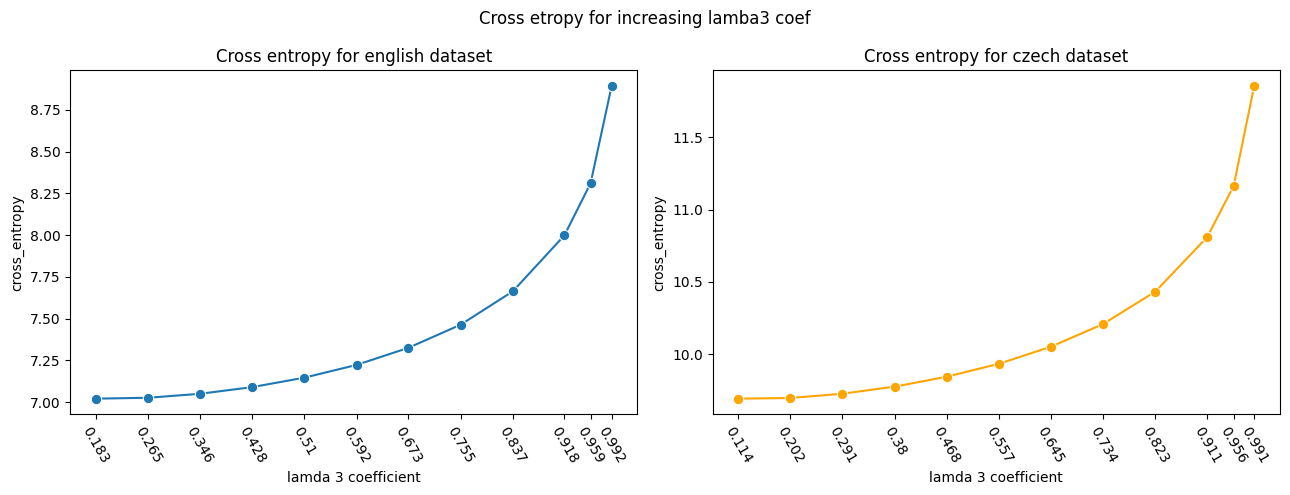

In [ ]:
# plot results for increasing l3 for both datasets
increase = results[(results['increase'] == True)]
figure, ax = plt.subplots(1,2, figsize = (13,5))

sns.lineplot(increase[increase['data'] == 'EN'], x='l3', y = 'cross_entropy', ax=ax[0], marker = '.', markersize = 15)
ax[0].set_title('Cross entropy for english dataset')
ax[0].set_xticks(increase[increase['data'] == 'EN'].l3)
ax[0].set_xticklabels(increase[increase['data'] == 'EN'].l3, rotation=-60)
ax[0].set_xlabel('lamda 3 coefficient')

ax[1] = sns.lineplot(increase[increase['data'] == 'CZ'], x='l3', y = 'cross_entropy', ax=ax[1],  marker = '.', markersize = 15, color = 'orange')
ax[1].set_title('Cross entropy for czech dataset')
ax[1].set_xticks(increase[increase['data'] == 'CZ'].l3)
ax[1].set_xticklabels(increase[increase['data'] == 'CZ'].l3, rotation=-60)
ax[1].set_xlabel('lamda 3 coefficient')

figure.suptitle('Cross etropy for increasing lamba3 coef')
plt.tight_layout()

In [ ]:
print('results for decreasing l3 and english data')
results[(results['data'] == 'EN') & (results['increase'] == False)][['proportion','cross_entropy','l3']]

results for decreasing l3 and english data


,proportion,cross_entropy,l3
12,0.0,7.191176,0.000
13,0.1,7.122549,0.018
14,0.2,7.092441,0.037
15,0.3,7.072087,0.055
16,0.4,7.057150,0.073
17,0.5,7.045860,0.092
18,0.6,7.037285,0.110
19,0.7,7.030862,0.128
20,0.8,7.026221,0.146
21,0.9,7.023106,0.165


In [ ]:
print('results for decreasing l3 and czech data')
results[(results['data'] == 'CZ') & (results['increase'] == False)][['proportion','cross_entropy','l3']]

results for decreasing l3 and czech data


,proportion,cross_entropy,l3
34,0.0,9.847796,0.000
35,0.1,9.775449,0.011
36,0.2,9.751137,0.023
37,0.3,9.735204,0.034
38,0.4,9.723614,0.045
39,0.5,9.714820,0.057
40,0.6,9.708031,0.068
41,0.7,9.702779,0.080
42,0.8,9.698762,0.091
43,0.9,9.695769,0.102


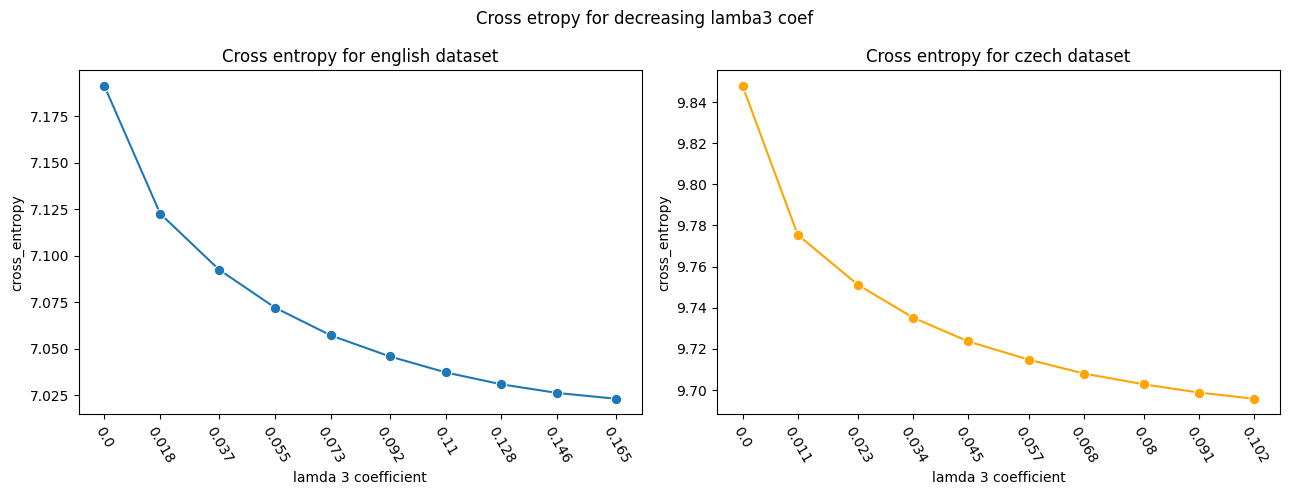

In [ ]:
# make plots for decreasing l3 of both cases
increase = results[(results['increase'] == False)]
figure, ax = plt.subplots(1,2, figsize = (13,5))

sns.lineplot(increase[increase['data'] == 'EN'], x='l3', y = 'cross_entropy', ax=ax[0], marker = '.', markersize = 15)
ax[0].set_title('Cross entropy for english dataset')
ax[0].set_xticks(increase[increase['data'] == 'EN'].l3)
ax[0].set_xticklabels(increase[increase['data'] == 'EN'].l3, rotation=-60)
ax[0].set_xlabel('lamda 3 coefficient')

ax[1] = sns.lineplot(increase[increase['data'] == 'CZ'], x='l3', y = 'cross_entropy', ax=ax[1],  marker = '.', markersize = 15, color = 'orange')
ax[1].set_title('Cross entropy for czech dataset')
ax[1].set_xticks(increase[increase['data'] == 'CZ'].l3)
ax[1].set_xticklabels(increase[increase['data'] == 'CZ'].l3, rotation=-60)
ax[1].set_xlabel('lamda 3 coefficient')

figure.suptitle('Cross etropy for decreasing lamba3 coef')
plt.tight_layout()

In [ ]:
# compute counts of train words that are also in test data
count_EN = 0
for word in data_ENG[:-t] :
  if word in test_data_EN: count_EN += 1
count_CZ = 0
for word in data_CZK[:-t] :
  if word in test_data_CZ: count_CZ += 1

(0.0, 120.0)

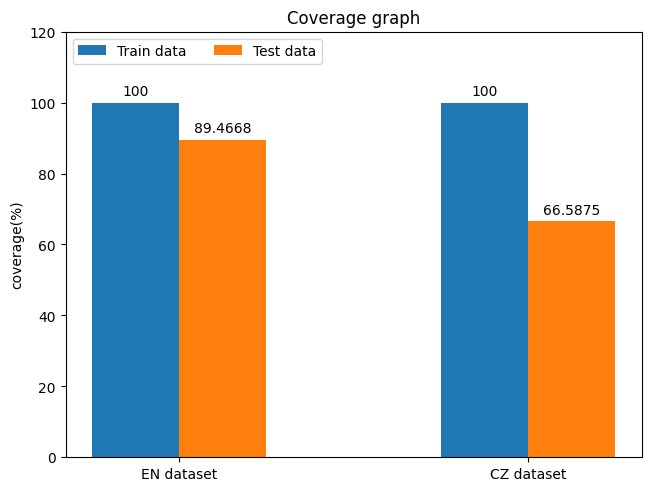

In [ ]:
# plot coverage graph
data = ("EN dataset", "CZ dataset")
coverage = {
    'Train data': (100, 100),
    'Test data': ( count_EN / (len(train_data_EN) + len(heldout_data_EN)) * 100,
                   count_CZ / (len(train_data_CZ) + len(heldout_data_CZ)) * 100)
}

x = np.arange(len(data))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in coverage.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('coverage(%)')
ax.set_title('Coverage graph')
ax.set_xticks(x + width/2, data)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 120)
